Required modules

In [0]:
!pip install coolprop

     |████████████████████████████████| 4.0MB 2.8MB/s 


In [0]:
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
import CoolProp.CoolProp as cp
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

###Function to calculate liquid production

It has two conditions: if the sum of xl and z is lower that 1 it returns the value of the function. If not it returns 0,99 minus the extraction percentage to the by-pass turbine.

* $h$ is the enthalpy at the point
*$\epsilon$ is the efficency of the heat exchangers
* $\eta_{iso} $ is the isoentropic efficiency
*$z$ is the extraction to the by-pass turbine

In [0]:
def prodliq_ap(h_1,h_3,eps,h_9,eta_iso,z,h_13,h_14,h_8):
    ## produção de líquido em regime permanente
    xl = ((h_1 - h_3 - (1 - eps) * (h_1 - h_9)) + eta_iso * z *(h_13-h_14)) / (h_1 - h_8 - (1 - eps) * (h_1 - h_9))
    if xl + z < 1:
        return xl
    else: 
        return 0.99 - z

### Parâmetros de Entrada

Eficiências

* C - Compressor 

* T - Turbina

* B - Bomba

T = temperatura em $K$

In [0]:
fluid = 'Nitrogen'

In [0]:
eta_c = 0.5
eta_iso = 0.8
eta_t = 0.85
eta_b = 0.75
T_0 = 298 # temperatura em K

In [0]:
h_0 = cp.PropsSI('H','T',T_0,'P',101325,fluid)
s_0 = cp.PropsSI('S','T',T_0,'P',101325,fluid)
k = 1.4
P_1 = 101325
P_2 = 4e6
P_3 = 2e7
T_4 = 293-33
T_1 = T_0
T_3 = T_1
T_19 = 400+273
T_8 = 77.3
Q_8 = 0
T_9 = 77.3
Q_9 = 1
T_7 = 77.3
T_15 = T_8
m_c = 5

### Propriedades termodinâmicas nos pontos

In [0]:
h_1 = cp.PropsSI('H','T',T_1,'P',P_1,fluid)
s_1 = cp.PropsSI('S','T',T_1,'P',P_1,fluid)
T_2 = T_1*(P_2 / P_1)**((k-1)/k)
h_2 = cp.PropsSI('H','T',T_2,'P',P_2,fluid)
s_2 = cp.PropsSI('S','T',T_2,'P',P_2,fluid)
h_12 = h_1
s_12 = s_1
h_3 = cp.PropsSI('H','T',T_3,'P',P_2,fluid)
s_3 = cp.PropsSI('S','T',T_3,'P',P_2,fluid)
h_8 = cp.PropsSI('H','T',T_8,'Q',Q_8,fluid)
s_8 = cp.PropsSI('S','T',T_8,'Q',Q_8,fluid)
h_9 = cp.PropsSI('H','T',T_9,'Q',Q_9,fluid)
s_9 = cp.PropsSI('S','T',T_9,'Q',Q_9,fluid)
h_4 = cp.PropsSI('H','T',T_4,'P',P_2,fluid)
s_4 = cp.PropsSI('S','T',T_4,'P',P_2,fluid)
h_13 = h_4
s_13 = s_4
T_13 = T_4
T_14 = T_13/((P_2/P_1)**((k-1)/k))
h_14 = cp.PropsSI('H','T',T_14,'P',P_1,fluid)
s_14 = cp.PropsSI('S','T',T_14,'P',P_1,fluid)
T_10 = T_14
h_10 = h_14
s_10 = s_14

### Produção de líquido durante o armazenamento

In [0]:
z1 = np.linspace(0,1,100)
eps1 = np.linspace(0,1,100)
zcombeps = np.ones([z1.size * eps1.size,2])
index = 0

In [0]:
[m,n] = zcombeps.shape

In [0]:
for i in z1:
    for j in eps1:
        zcombeps[index, 0] = j
        zcombeps[index, 1] = i
        index += 1

In [0]:
z = zcombeps[:,1]

In [0]:
eps = zcombeps[:,0]

In [0]:
x = np.ones(m)
index = 0

In [0]:
for i in z:
    x[index] = prodliq_ap(h_1,h_3,eps[index],h_9,eta_iso,z[index],h_13,h_14,h_8)
    if x[index] < 0:
        x[index] = np.nan
    index += 1

In [0]:
[X,Y] = np.meshgrid(z,eps)

In [0]:
Z = griddata((z,eps),x,(X,Y) , method = 'linear')

## Gráfico de contorno da produção de líquido

O gráfico mostra a produção de líquido durante o carregamento em regime permanente em função da efetividade e do percentual de extração para  turbina 1.

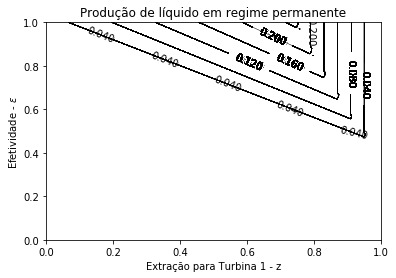

In [0]:
[fig, ax] = plt.subplots()
CS = ax.contour(X, Y, Z, 6, colors = 'k', linewidths = 0.5)
ax.clabel(CS, inline = True, inline_spacing = 7, fontsize=10)
ax.set_title('Produção de líquido em regime permanente')
plt.xlabel('Extração para Turbina 1 - z')
plt.ylabel('Efetividade - $\epsilon$')
plt.savefig('prodliq_ap.jpg', dpi = 600)

In [0]:
m_l = x * m_c
m_b = m_l

### Propriedades no circuito de geração durante o armazenamento

In [0]:
h_15 = cp.PropsSI('H', 'T', T_15, 'P', P_3, fluid)
s_15 = cp.PropsSI('S', 'T', T_15, 'P', P_3, fluid)
h_16 = h_15 # não há vazão no TC4
T_16 = T_15 # não há vazão no TC4
h_17 = h_16 + 150000 # carga térmica no TC5 150 kJ / kg
T_17 = cp.PropsSI('T', 'H', h_17, 'P', P_3, fluid)
s_17 = cp.PropsSI('S', 'T', T_17, 'P', P_3, fluid)
T_18 = 273 + 35 # temperatura de saída do cooler
h_18 = cp.PropsSI('H', 'T', T_18, 'P', P_3, fluid)
s_18 = cp.PropsSI('S', 'T', T_18, 'P', P_3, fluid)
h_19 = cp.PropsSI('H', 'T', T_19, 'P', P_3, fluid)
s_19 = cp.PropsSI('S', 'T', T_19, 'P', P_3, fluid)
T_20 = T_19 / ((P_3 / P_1) ** ((k - 1) / k))
h_20 = cp.PropsSI('H', 'T', T_20, 'P', P_3, fluid)
s_20 = cp.PropsSI('S', 'T', T_20, 'P', P_3, fluid)

### Trabalho e potência

Volume de controle nos equipamentos para cálculo de trabalhos e potências e cargas térmicas

$\dot{W}$ - Potência = W

$w$ - trabalho = w

In [0]:
w_c = (h_2 - h_1) / eta_c # (hs - he) / (eta_c) --  (hs, he, eta_c)
w_c
w_b
W_b = w_b * m_b # Potência W e trabalho w 
w_T1 = # (he, hs, eta_t) -- (he - hs) * eta_t
W_T1 = 
w_T2 = 
W_T2 = 
## Trocador de calor (hs, he) -- q_t = hs - he
